<a href="https://colab.research.google.com/github/cdwangco/SentimentAnalysisProject/blob/main/MLProjectYTSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import warnings
warnings.filterwarnings('ignore')

In [2]:
#input data source here
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [3]:
df.head()
df[1].value_counts() #we have a balanced data set
df = df[:2000]

In [4]:
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, accuracy_score


In [8]:
def getSubj(text):
  return TextBlob(text).sentiment.subjectivity

def getPol(text):
  return TextBlob(text).sentiment.polarity

def binarize(float):
  return 1 if float > 0 else 0
  


In [14]:

data = df.rename(columns={0: 'Comment', 1:'Label'})
data['Polarity'] = data['Comment'].apply(getPol)
data['Prediction'] = data['Polarity'].apply(binarize)
data.head()

,Comment,Label,Polarity,Prediction
0,"a stirring , funny and finally transporting re...",1,0.125000,1
1,apparently reassembled from the cutting room f...,0,-0.275000,0
2,they presume their audience wo n't sit still f...,0,0.178571,1
3,this is a visually stunning rumination on love...,1,0.500000,1
4,jonathan parker 's bartleby should have been t...,1,0.200000,1


In [15]:

!pip install transformers
import transformers as ppb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
# Do BERT in parallel to compare baseline performance
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
tokenized = data['Comment'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.head())

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

print(np.array(padded).shape)

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)



0    [101, 1037, 18385, 1010, 6057, 1998, 2633, 182...
1    [101, 4593, 2128, 27241, 23931, 2013, 1996, 62...
2    [101, 2027, 3653, 23545, 2037, 4378, 24185, 10...
3    [101, 2023, 2003, 1037, 17453, 14726, 19379, 1...
4    [101, 5655, 6262, 1005, 1055, 12075, 2571, 376...
Name: Comment, dtype: object
(2000, 59)
(2000, 59)


In [18]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

features = last_hidden_states[0][:,0,:].numpy()

In [20]:
lr_clf = LogisticRegression()
clf = lr_clf.fit(features,data['Label'])
data['Bert'] = clf.predict(features)
data.head()
print(lr_clf.score(features, data['Label']))

0.9085


In [35]:
print('TextBlob Confusion Matrix')
print(confusion_matrix(data['Label'],data['Prediction']))
textBlobAcc = accuracy_score(data['Label'],data['Prediction'])
print(textBlobAcc)

print('BERT Confusion Matrix')
print(confusion_matrix(data['Label'],data['Bert']))
bertAcc = accuracy_score(data['Label'],data['Bert'])
print(bertAcc)

names = ['TextBlob', 'BERT']
accuracies = [textBlobAcc,bertAcc]

TextBlob Confusion Matrix
[[571 388]
 [292 749]]
0.66
BERT Confusion Matrix
[[879  80]
 [103 938]]
0.9085


<BarContainer object of 2 artists>

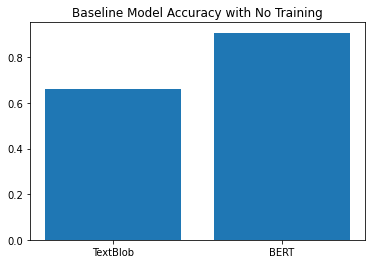

In [36]:
import matplotlib.pyplot as plt

plt.title('Baseline Model Accuracy with No Training')
plt.bar(names,accuracies)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')